# Environment Setup & Model Loading

## System Check

In [1]:
# 检查GPU和内存状态
import torch
import psutil

print("=== 系统信息 ===")
print(f"Python版本: {torch.__version__}")
print(f"CUDA可用: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU设备: {torch.cuda.get_device_name(0)}")
    print(f"GPU内存: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB")

print(f"系统RAM: {psutil.virtual_memory().total // 1024**3} GB")
print(f"可用RAM: {psutil.virtual_memory().available // 1024**3} GB")

# 设置内存增长策略
torch.cuda.empty_cache()

=== 系统信息 ===
Python版本: 2.8.0+cu126
CUDA可用: True
GPU设备: NVIDIA A100-SXM4-40GB
GPU内存: 39 GB
系统RAM: 83 GB
可用RAM: 79 GB


## Package Installation

In [2]:
# 安装核心库 (移除bitsandbytes，因为不需要量化)
!pip install --quiet transformers>=4.40.0
!pip install --quiet torch>=2.0.0
!pip install --quiet accelerate
!pip install --quiet plotly
!pip install --quiet numpy pandas matplotlib seaborn
!pip install --quiet tqdm

# 重启运行时（运行完这个cell后，在菜单栏选择"运行时" -> "重启运行时"）
print("安装完成！请重启运行时然后继续下一步。")

安装完成！请重启运行时然后继续下一步。


## Restart Reminder
⚠️ Important: After installation, please select "Runtime" → "Restart session" from the menu bar, then continue running the following cells.

## Load Gemma 2 2B

In [1]:
# Load Gemma 2 2B in FP16
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc

print("开始加载Gemma 2 2B模型 (FP16精度)...")

# 加载模型和tokenizer
try:
    print("正在加载tokenizer...")
    tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b")

    print("正在加载模型（FP16精度，这可能需要几分钟）...")
    model = AutoModelForCausalLM.from_pretrained(
        "google/gemma-2-2b",
        device_map="auto",
        torch_dtype=torch.float16,  # 使用FP16精度
        trust_remote_code=True,
        low_cpu_mem_usage=True,  # 降低CPU内存使用
    )

    print(f"✅ 模型成功加载到设备: {next(model.parameters()).device}")
    print(f"模型数据类型: {next(model.parameters()).dtype}")
    print(f"模型参数数量: {sum(p.numel() for p in model.parameters()):,}")

    # 检查模型结构
    print(f"模型层数: {model.config.num_hidden_layers}")
    print(f"隐藏层维度: {model.config.hidden_size}")
    print(f"词汇表大小: {model.config.vocab_size}")

    # 显示内存使用情况
    if torch.cuda.is_available():
        print(f"GPU内存使用: {torch.cuda.memory_allocated() // 1024**2} MB")
        print(f"GPU内存缓存: {torch.cuda.memory_reserved() // 1024**2} MB")

except Exception as e:
    print(f"❌ 模型加载失败: {e}")
    print("请检查网络连接或尝试重新运行此cell")
    print("如果内存不足，请考虑使用更小的模型或者启用量化")

开始加载Gemma 2B模型 (FP16精度)...
正在加载tokenizer...
正在加载模型（FP16精度，这可能需要几分钟）...


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

✅ 模型成功加载到设备: cuda:0
模型数据类型: torch.float16
模型参数数量: 2,614,341,888
模型层数: 26
隐藏层维度: 2304
词汇表大小: 256000
GPU内存使用: 4986 MB
GPU内存缓存: 5114 MB


## Model Test

In [2]:
# 测试模型生成
test_prompt = "The capital of France is"
print(f"测试提示: '{test_prompt}'")

# 编码输入
inputs = tokenizer(test_prompt, return_tensors="pt").to(model.device)
print(f"输入token数量: {len(inputs['input_ids'][0])}")
print(f"输入tokens: {tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])}")

# 生成文本
with torch.no_grad():
    outputs = model.generate(
        inputs['input_ids'],
        max_new_tokens=10,
        temperature=0.7,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id
    )

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"生成结果: '{generated_text}'")

# 获取logits分析
with torch.no_grad():
    model_outputs = model(**inputs, output_hidden_states=True)
    logits = model_outputs.logits[0, -1]  # 最后一个token的logits
    probs = torch.softmax(logits, dim=-1)

    # 获取top-5预测
    top_probs, top_indices = torch.topk(probs, 5)
    print("\n=== Top 5 预测 ===")
    for i, (prob, idx) in enumerate(zip(top_probs, top_indices)):
        token = tokenizer.decode([idx])
        print(f"{i+1}. '{token}' - 概率: {prob:.4f}")

    # 熵计算
    def safe_entropy_calculation(logits):
        """更稳健的熵计算方法"""
        try:
            # 检查logits是否异常
            if torch.isnan(logits).any() or torch.isinf(logits).any():
                print("❌ Logits包含异常值")
                return None

            # 使用log_softmax避免数值问题
            log_probs = torch.log_softmax(logits, dim=-1)
            probs = torch.softmax(logits, dim=-1)

            # 检查概率是否异常
            if torch.isnan(probs).any() or torch.isinf(probs).any():
                print("❌ 概率计算异常")
                return None

            # 计算熵
            entropy = -torch.sum(probs * log_probs)

            if torch.isnan(entropy) or torch.isinf(entropy):
                print("❌ 熵计算结果异常")
                return None

            return entropy.item()

        except Exception as e:
            print(f"❌ 熵计算错误: {e}")
            return None

    entropy = safe_entropy_calculation(logits)
    if entropy is not None:
        print(f"\n✅ 预测熵（不确定性）: {entropy:.4f}")
    else:
        print(f"\n❌ 熵计算失败")
        # 使用替代度量
        top1_prob = torch.max(torch.softmax(logits, dim=-1))
        print(f"替代度量 - Top-1概率: {top1_prob:.4f} (越高越确定)")
        print(f"不确定性估计: {1-top1_prob:.4f}")

print("\n✅ 模型测试完成，准备开始分析不确定性神经元！")

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


测试提示: 'The capital of France is'
输入token数量: 6
输入tokens: ['<bos>', 'The', '▁capital', '▁of', '▁France', '▁is']
生成结果: 'The capital of France is located in the heart of the country. The city'

=== Top 5 预测 ===
1. ' a' - 概率: 0.2076
2. ' the' - 概率: 0.0996
3. ' one' - 概率: 0.0813
4. ' also' - 概率: 0.0776
5. ' home' - 概率: 0.0509

✅ 预测熵（不确定性）: 3.4180

✅ 模型测试完成，准备开始分析不确定性神经元！


# Neuron Analysis

## Test Dataset

In [3]:
# 不确定性神经元测试数据集
# 基于不同类型的不确定性设计测试句子

uncertainty_test_dataset = {

    # 1. Epistemic Uncertainty (认知不确定性)
    # 模型知识不足导致的不确定性，理论上可以通过更多训练数据解决
    "epistemic": {
        "description": "模型知识不足导致的不确定性",
        "expected_behavior": "高不确定性，模型不知道答案",
        "sentences": [
            # Obscure factual knowledge
            "The population of Nauru in 2024 is",
            "The CEO of startup company Zephyr Labs is",
            "The atomic weight of Flerovium is",
            "The mayor of Vaduz, Liechtenstein is",
            "The 47th element on the periodic table is",
            "The director of the 1927 film Metropolis was",
            "The winner of the 1952 Nobel Prize in Chemistry was",
            "The height of Mount Vinson in Antarctica is",
            # Technical/specialized knowledge
            "The Hausdorff dimension of the Sierpinski triangle is",
            "The IUPAC name for water is",
            "The half-life of Carbon-14 is",
            "The speed of sound in helium at 20°C is"
        ]
    },

    # 2. Aleatoric Uncertainty (随机不确定性)
    # 输入本身固有的模糊性，即使有完美模型也无法确定
    "aleatoric": {
        "description": "输入固有的模糊性和多义性",
        "expected_behavior": "中等到高不确定性，多个合理答案",
        "sentences": [
            # Subjective/opinion-based completions
            "The best programming language is",
            "The most important thing in life is",
            "The greatest movie of all time is",
            "The most beautiful color is",
            "The meaning of happiness is",
            "Success is defined as",
            # Open-ended continuations with multiple valid paths
            "She told him that",
            "They decided to go",
            "The reason for this is",
            "After thinking about it,",
            "The story ended when",
            # Lexical ambiguity (word-level multiple meanings)
            "The bank is",
            "The bat flew",
            "She couldn't bear",
            "The seal swam",
            "The light solution is"
        ]
    },

    # 3. Linguistic Uncertainty (语言不确定性)
    # 语言结构或语法导致的不确定性
    "linguistic": {
        "description": "语言结构和语法导致的不确定性",
        "expected_behavior": "结构性不确定性，语法解析困难",
        "sentences": [
            # PP-attachment ambiguity
            "The man saw the boy with the telescope",
            "She hit the man with the umbrella",
            "They discussed the plan in the office",
            "I saw the Grand Canyon flying to New York",
            # Syntactic ambiguity
            "Flying planes can be dangerous",
            "They are hunting dogs",
            "Visiting relatives can be boring",
            "The shooting of the hunters was terrible",
            # Garden path sentences
            "The horse raced past the barn fell",
            "The old man the boats",
            "The complex houses married and single soldiers",
            "The prime number few",
            # Coordination ambiguity
            "Old men and women were served first",
            "I saw her duck and cover"
        ]
    },

    # 4. Low Uncertainty Controls (低不确定性对照组)
    # 确定性高的句子，作为基线对照
    "low_uncertainty": {
        "description": "高确定性句子，作为基线对照",
        "expected_behavior": "低不确定性，明确的预期答案",
        "sentences": [
            # Basic facts
            "The capital of USA is",
            "Two plus two equals",
            "The sun rises in the",
            "The first letter of the alphabet is",
            "Christmas is celebrated on December",
            # Common knowledge
            "The color of grass is",
            "The Earth orbits the",
            "The opposite of hot is",
            "One meter equals one hundred"
        ]
    },
}

def print_dataset_summary():
    """打印数据集摘要"""
    total_sentences = 0
    print("=== 不确定性测试数据集摘要 ===\n")

    for category, data in uncertainty_test_dataset.items():
        num_sentences = len(data["sentences"])
        total_sentences += num_sentences

        print(f"📊 {category.upper().replace('_', ' ')} ({num_sentences} 句子)")
        print(f"   描述: {data['description']}")
        print(f"   预期行为: {data['expected_behavior']}")
        print("   示例句子:")
        for i, sentence in enumerate(data["sentences"][:2]):  # 只显示前2个
            print(f"     • '{sentence}'")
        if num_sentences > 2:
            print(f"     ... 还有 {num_sentences - 2} 个句子")
        print()

    print(f"📈 总计: {total_sentences} 个测试句子")
    print(f"⏱️  预计实验时间: {total_sentences * 0.5:.1f}-{total_sentences * 1:.1f} 分钟")
    return total_sentences

def get_test_sentences_by_category(category=None, limit_per_category=None):
    """
    获取指定类别的测试句子

    Args:
        category: 指定类别，None表示全部
        limit_per_category: 每个类别的句子数量限制
    """
    if category and category in uncertainty_test_dataset:
        sentences = uncertainty_test_dataset[category]["sentences"]
        if limit_per_category:
            sentences = sentences[:limit_per_category]
        return [(sentence, category) for sentence in sentences]

    # 返回所有类别
    all_sentences = []
    for cat, data in uncertainty_test_dataset.items():
        sentences = data["sentences"]
        if limit_per_category:
            sentences = sentences[:limit_per_category]
        all_sentences.extend([(sentence, cat) for sentence in sentences])

    return all_sentences

def get_recommended_test_set(quick_test=True):
    """
    获取推荐的测试集

    Args:
        quick_test: True = 快速测试(每类3-4句), False = 完整测试
    """
    if quick_test:
        print("🚀 推荐：快速测试集 (每类3-4个句子，总计约15个)")
        limit = 4
    else:
        print("🔬 推荐：完整测试集 (所有句子)")
        limit = None

    return get_test_sentences_by_category(limit_per_category=limit)

# 显示数据集信息
total_count = print_dataset_summary()

# 提供使用建议
print("💡 使用建议:")
print("   • 第一次实验：使用 get_recommended_test_set(quick_test=True)")
print("   • 详细分析：使用 get_recommended_test_set(quick_test=False)")
print("   • 特定分析：使用 get_test_sentences_by_category('epistemic')")
print("\n✅ 测试数据集准备完成！")

=== 不确定性测试数据集摘要 ===

📊 EPISTEMIC (12 句子)
   描述: 模型知识不足导致的不确定性
   预期行为: 高不确定性，模型不知道答案
   示例句子:
     • 'The population of Nauru in 2024 is'
     • 'The CEO of startup company Zephyr Labs is'
     ... 还有 10 个句子

📊 ALEATORIC (16 句子)
   描述: 输入固有的模糊性和多义性
   预期行为: 中等到高不确定性，多个合理答案
   示例句子:
     • 'The best programming language is'
     • 'The most important thing in life is'
     ... 还有 14 个句子

📊 LINGUISTIC (14 句子)
   描述: 语言结构和语法导致的不确定性
   预期行为: 结构性不确定性，语法解析困难
   示例句子:
     • 'The man saw the boy with the telescope'
     • 'She hit the man with the umbrella'
     ... 还有 12 个句子

📊 LOW UNCERTAINTY (9 句子)
   描述: 高确定性句子，作为基线对照
   预期行为: 低不确定性，明确的预期答案
   示例句子:
     • 'The capital of USA is'
     • 'Two plus two equals'
     ... 还有 7 个句子

📈 总计: 51 个测试句子
⏱️  预计实验时间: 25.5-51.0 分钟
💡 使用建议:
   • 第一次实验：使用 get_recommended_test_set(quick_test=True)
   • 详细分析：使用 get_recommended_test_set(quick_test=False)
   • 特定分析：使用 get_test_sentences_by_category('epistemic')

✅ 测试数据集准备完成！


## Weight Extraction

In [4]:
print("开始提取最后一层神经元权重...")

# 获取模型的最后一层
last_layer_idx = model.config.num_hidden_layers - 1
print(f"分析第{last_layer_idx}层（最后一层）")

# 提取最后一层的输出权重和unembedding矩阵
try:
    # Gemma 2的结构访问
    last_layer = model.model.layers[last_layer_idx]

    # 获取MLP的输出权重 (hidden_size, intermediate_size)
    mlp_gate_proj = last_layer.mlp.gate_proj.weight.data  # (intermediate_size, hidden_size)
    mlp_up_proj = last_layer.mlp.up_proj.weight.data      # (intermediate_size, hidden_size)
    mlp_down_proj = last_layer.mlp.down_proj.weight.data  # (hidden_size, intermediate_size)

    # 获取unembedding矩阵
    unembed_matrix = model.lm_head.weight.data  # (vocab_size, hidden_size)

    print(f"MLP gate projection形状: {mlp_gate_proj.shape}")
    print(f"MLP up projection形状: {mlp_up_proj.shape}")
    print(f"MLP down projection形状: {mlp_down_proj.shape}")
    print(f"Unembedding矩阵形状: {unembed_matrix.shape}")

    # 计算有效的输出权重 (我们关注down_proj，它是MLP的输出)
    W_out = mlp_down_proj.T  # 转置为 (intermediate_size, hidden_size)
    print(f"输出权重矩阵形状: {W_out.shape}")
    print(f"设备: {W_out.device}")
    print(f"数据类型: {W_out.dtype}")

    # 转换为CPU进行分析，保持FP16精度
    W_out_cpu = W_out.cpu()  # 保持FP16
    unembed_cpu = unembed_matrix.cpu()  # 保持FP16

    print("✅ 权重提取完成！")

except Exception as e:
    print(f"❌ 权重提取失败: {e}")
    print("模型结构可能与预期不同，让我们检查实际结构...")

    # 打印模型结构以便调试
    print("\n=== 模型结构检查 ===")
    for name, module in model.named_modules():
        if 'layer' in name and 'mlp' in name:
            print(f"{name}: {type(module)}")
            if hasattr(module, 'weight'):
                print(f"  权重形状: {module.weight.shape}")

开始提取最后一层神经元权重...
分析第25层（最后一层）
MLP gate projection形状: torch.Size([9216, 2304])
MLP up projection形状: torch.Size([9216, 2304])
MLP down projection形状: torch.Size([2304, 9216])
Unembedding矩阵形状: torch.Size([256000, 2304])
输出权重矩阵形状: torch.Size([9216, 2304])
设备: cuda:0
数据类型: torch.float16
✅ 权重提取完成！


## LogitVar Calculation

In [6]:
# 计算每个神经元的LogitVar和权重范数
print("计算LogitVar指标...")

def calculate_logit_var(neuron_weights, unembed_matrix):
    """
    计算神经元的LogitVar指标
    LogitVar(i) = Var(W_out^(i) @ W_U / ||W_out^(i) @ W_U||_2)
    """
    # 确保计算精度，转换为float32进行数值计算
    neuron_weights_f32 = neuron_weights.float()
    unembed_matrix_f32 = unembed_matrix.float()

    # 计算神经元权重与unembedding的乘积
    projections = neuron_weights_f32 @ unembed_matrix_f32.T
    norms = torch.norm(projections, dim=1, keepdim=True)

    # 计算每个神经元投影的L2范数 标准化投影
    norms = torch.clamp(norms, min=1e-10)  # 增加最小值
    normalized_projections = projections / norms

    # 计算每个神经元标准化投影的方差
    mask = torch.isfinite(normalized_projections).all(dim=1)
    logit_vars = torch.full((normalized_projections.shape[0],), float('nan'))
    logit_vars[mask] = torch.var(normalized_projections[mask], dim=1)

    return logit_vars, norms.squeeze()

# 执行计算
try:
    print(f"计算{W_out_cpu.shape[0]}个神经元的指标...")

    logit_vars, projection_norms = calculate_logit_var(W_out_cpu, unembed_cpu)

    # 计算输出权重的L2范数
    weight_norms = torch.norm(W_out_cpu.float(), dim=1)  # 每个神经元权重向量的范数

    print(f"LogitVar计算完成: {logit_vars.shape}")
    print(f"权重范数计算完成: {weight_norms.shape}")
    print(f"投影范数计算完成: {projection_norms.shape}")

    # 基本统计
    print(f"\n=== 统计摘要 ===")
    print(f"LogitVar - 均值: {logit_vars.mean():.6f}, 标准差: {logit_vars.std():.6f}")
    print(f"权重范数 - 均值: {weight_norms.mean():.6f}, 标准差: {weight_norms.std():.6f}")
    print(f"投影范数 - 均值: {projection_norms.mean():.6f}, 标准差: {projection_norms.std():.6f}")

    # 寻找异常值（低LogitVar但高权重范数的神经元）
    logit_var_threshold = logit_vars.quantile(0.1)  # 最低10%的LogitVar
    weight_norm_threshold = weight_norms.quantile(0.9)  # 最高10%的权重范数

    # 候选不确定性神经元
    uncertainty_candidates = (logit_vars < logit_var_threshold) & (weight_norms > weight_norm_threshold)
    num_candidates = uncertainty_candidates.sum().item()

    print(f"\n=== 候选不确定性神经元 ===")
    print(f"低LogitVar阈值: {logit_var_threshold:.6f}")
    print(f"高权重范数阈值: {weight_norm_threshold:.6f}")
    print(f"找到候选神经元: {num_candidates} 个")

    if num_candidates > 0:
        candidate_indices = torch.where(uncertainty_candidates)[0]
        print(f"候选神经元索引: {candidate_indices.tolist()}")

        # 显示前5个候选神经元的详细信息
        for i, idx in enumerate(candidate_indices[:5]):
            print(f"  神经元 {idx.item()}: LogitVar={logit_vars[idx]:.6f}, 权重范数={weight_norms[idx]:.6f}")

    print("\n✅ LogitVar分析完成！")

except Exception as e:
    print(f"❌ 计算失败: {e}")
    import traceback
    traceback.print_exc()

计算LogitVar指标...
计算9216个神经元的指标...
LogitVar计算完成: torch.Size([9216])
权重范数计算完成: torch.Size([9216])
投影范数计算完成: torch.Size([9216])

=== 统计摘要 ===
LogitVar - 均值: 0.000004, 标准差: 0.000001
权重范数 - 均值: 0.332084, 标准差: 0.050034
投影范数 - 均值: 5.787321, 标准差: 1.843591

=== 候选不确定性神经元 ===
低LogitVar阈值: 0.000003
高权重范数阈值: 0.373571
找到候选神经元: 29 个
候选神经元索引: [128, 965, 1064, 1689, 1939, 1974, 2058, 2109, 2181, 2656, 2928, 3461, 5002, 5076, 5252, 5255, 5430, 5807, 5974, 6053, 6107, 6481, 6680, 6827, 7821, 8133, 8786, 8830, 9115]
  神经元 128: LogitVar=0.000003, 权重范数=0.374931
  神经元 965: LogitVar=0.000003, 权重范数=0.374627
  神经元 1064: LogitVar=0.000002, 权重范数=0.374023
  神经元 1689: LogitVar=0.000003, 权重范数=0.384904
  神经元 1939: LogitVar=0.000003, 权重范数=0.381943

✅ LogitVar分析完成！


## Visualization

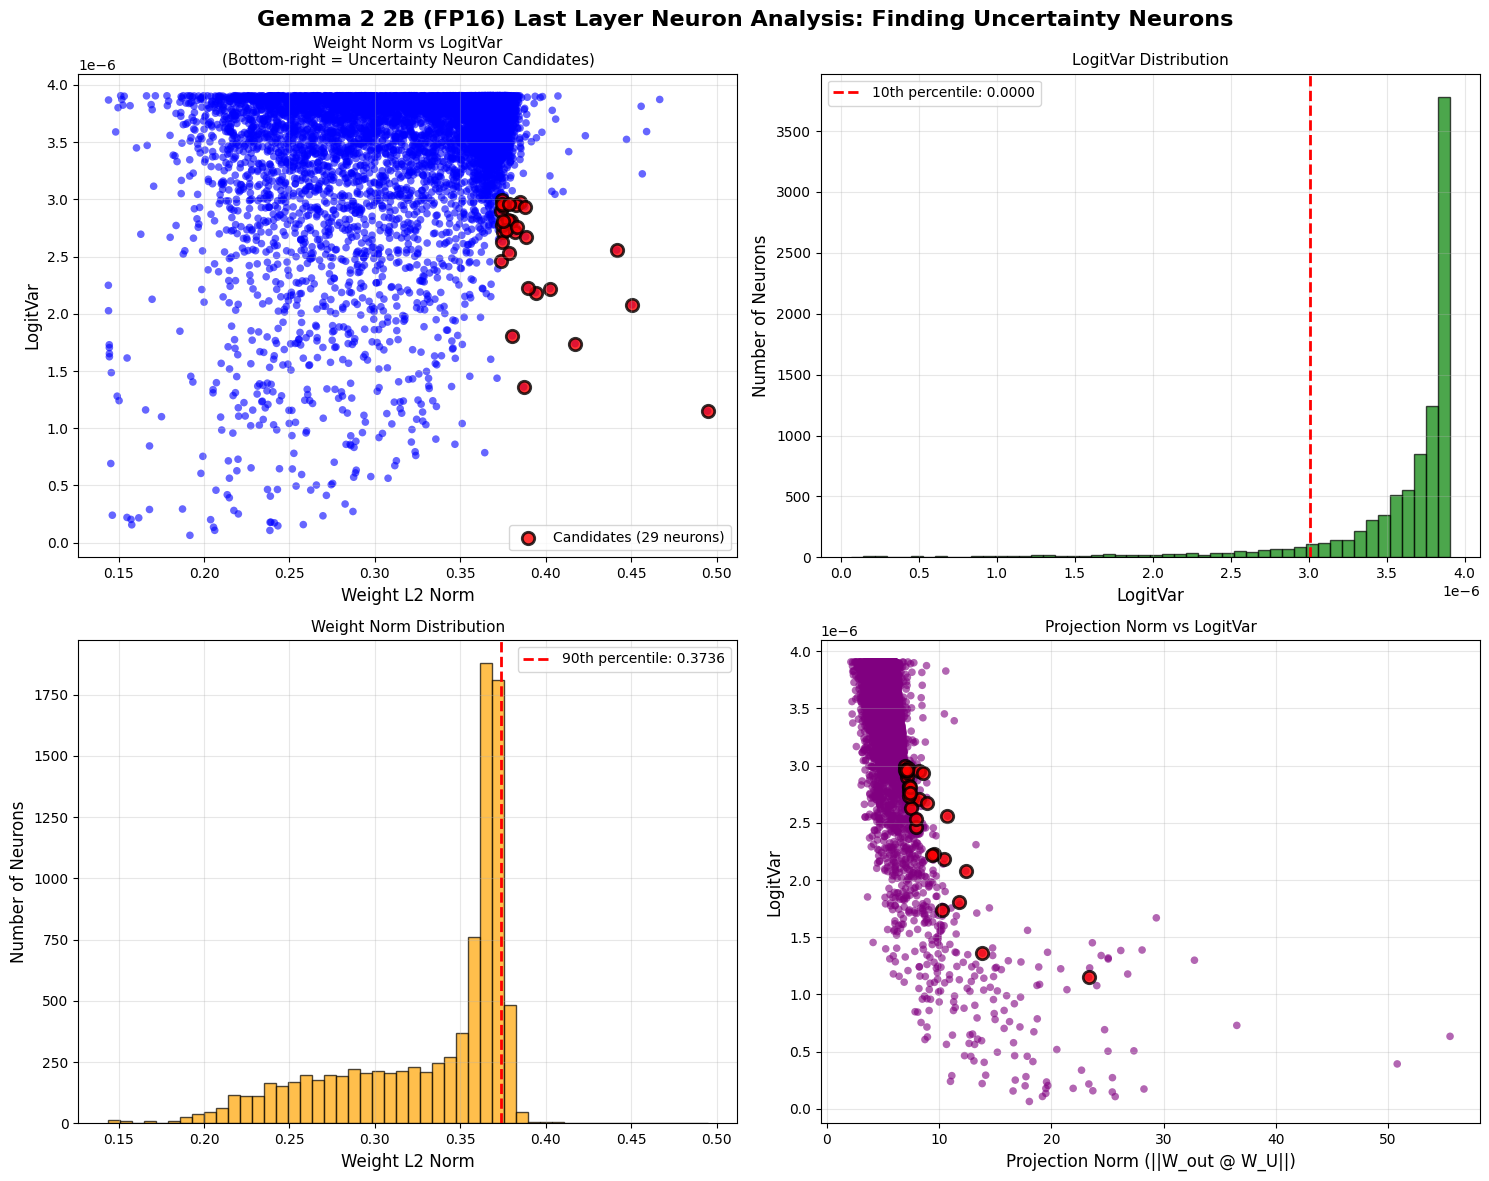

=== Detailed Analysis Results ===
Total number of neurons: 9216
Candidate uncertainty neurons: 29

=== Top 29 Candidate Neuron Details ===
Neuron  128: LogitVar=2.7168e-06, Weight norm=0.3749, Projection norm=7.5957
Neuron  965: LogitVar=2.9987e-06, Weight norm=0.3746, Projection norm=6.9326
Neuron 1064: LogitVar=2.4596e-06, Weight norm=0.3740, Projection norm=7.9744
Neuron 1689: LogitVar=2.9800e-06, Weight norm=0.3849, Projection norm=7.2090
Neuron 1939: LogitVar=2.7109e-06, Weight norm=0.3819, Projection norm=8.2010
Neuron 1974: LogitVar=1.8079e-06, Weight norm=0.3804, Projection norm=11.7652
Neuron 2058: LogitVar=2.8152e-06, Weight norm=0.3798, Projection norm=7.3561
Neuron 2109: LogitVar=2.6296e-06, Weight norm=0.3746, Projection norm=7.5450
Neuron 2181: LogitVar=2.9502e-06, Weight norm=0.3828, Projection norm=8.2366
Neuron 2656: LogitVar=2.0785e-06, Weight norm=0.4504, Projection norm=12.3741
Neuron 2928: LogitVar=2.1863e-06, Weight norm=0.3940, Projection norm=10.4847
Neuron 3461

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create scatter plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Gemma 2 2B (FP16) Last Layer Neuron Analysis: Finding Uncertainty Neurons', fontsize=16, fontweight='bold')

# 1. Main scatter plot: Weight norm vs LogitVar
ax1 = axes[0, 0]
scatter = ax1.scatter(weight_norms, logit_vars, alpha=0.6, s=30, c='blue', edgecolors='none')
ax1.set_xlabel('Weight L2 Norm', fontsize=12)
ax1.set_ylabel('LogitVar', fontsize=12)
ax1.set_title('Weight Norm vs LogitVar\n(Bottom-right = Uncertainty Neuron Candidates)', fontsize=11)
ax1.grid(True, alpha=0.3)

# Mark candidate uncertainty neurons
if num_candidates > 0:
    candidate_x = weight_norms[uncertainty_candidates]
    candidate_y = logit_vars[uncertainty_candidates]
    ax1.scatter(candidate_x, candidate_y, c='red', s=80, marker='o',
               edgecolors='black', linewidths=2, alpha=0.8, label=f'Candidates ({num_candidates} neurons)')
    ax1.legend()

# 2. LogitVar distribution histogram
ax2 = axes[0, 1]
ax2.hist(logit_vars.numpy(), bins=50, alpha=0.7, color='green', edgecolor='black')
ax2.axvline(logit_var_threshold, color='red', linestyle='--', linewidth=2, label=f'10th percentile: {logit_var_threshold:.4f}')
ax2.set_xlabel('LogitVar', fontsize=12)
ax2.set_ylabel('Number of Neurons', fontsize=12)
ax2.set_title('LogitVar Distribution', fontsize=11)
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Weight norm distribution histogram
ax3 = axes[1, 0]
ax3.hist(weight_norms.numpy(), bins=50, alpha=0.7, color='orange', edgecolor='black')
ax3.axvline(weight_norm_threshold, color='red', linestyle='--', linewidth=2, label=f'90th percentile: {weight_norm_threshold:.4f}')
ax3.set_xlabel('Weight L2 Norm', fontsize=12)
ax3.set_ylabel('Number of Neurons', fontsize=12)
ax3.set_title('Weight Norm Distribution', fontsize=11)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Projection norm vs LogitVar
ax4 = axes[1, 1]
ax4.scatter(projection_norms, logit_vars, alpha=0.6, s=30, c='purple', edgecolors='none')
ax4.set_xlabel('Projection Norm (||W_out @ W_U||)', fontsize=12)
ax4.set_ylabel('LogitVar', fontsize=12)
ax4.set_title('Projection Norm vs LogitVar', fontsize=11)
ax4.grid(True, alpha=0.3)

if num_candidates > 0:
    candidate_proj = projection_norms[uncertainty_candidates]
    ax4.scatter(candidate_proj, candidate_y, c='red', s=80, marker='o',
               edgecolors='black', linewidths=2, alpha=0.8)

plt.tight_layout()
plt.show()

# Print detailed analysis results
print("=== Detailed Analysis Results ===")
print(f"Total number of neurons: {len(weight_norms)}")
print(f"Candidate uncertainty neurons: {num_candidates}")

if num_candidates > 0:
    print(f"\n=== Top {min(30, num_candidates)} Candidate Neuron Details ===")
    candidate_indices = torch.where(uncertainty_candidates)[0]
    for i, idx in enumerate(candidate_indices[:min(30, num_candidates)]):
        idx_val = idx.item()
        print(f"Neuron {idx_val:4d}: "
              f"LogitVar={logit_vars[idx]:.4e}, "
              f"Weight norm={weight_norms[idx]:.4f}, "
              f"Projection norm={projection_norms[idx]:.4f}")

    # Save candidate neuron indices for subsequent analysis
    top_candidates = candidate_indices[:5] if num_candidates >= 5 else candidate_indices
    print(f"\nSelecting top {len(top_candidates)} neurons for further validation: {top_candidates.tolist()}")
else:
    print("No obvious candidate uncertainty neurons found")
    # Select some boundary cases for analysis
    sorted_indices = torch.argsort(logit_vars)
    top_candidates = sorted_indices[:3]  # Top 3 neurons with lowest LogitVar
    print(f"Selecting 3 neurons with lowest LogitVar for analysis: {top_candidates.tolist()}")

print("\n✅ Visualization analysis completed! Next we will validate the causal effects of these candidate neurons.")

# Causal Inference Experiment

## Causal Verification Experiment Setup

In [13]:
# 因果验证：激活补丁实验
print("准备因果验证实验...")

def calculate_entropy(logits):
    """计算预测的熵（不确定性度量）"""
    log_probs = torch.log_softmax(logits, dim=-1)
    probs = torch.softmax(logits, dim=-1)
    entropy = -torch.sum(probs * log_probs, dim=-1)
    return entropy

def create_hook_fn(layer_idx, neuron_indices, intervention_type='zero'):
    """创建激活干预的hook函数"""
    def hook_fn(module, input, output):
        # Gemma 2的MLP输出通常是hidden states
        if intervention_type == 'zero':
            # 将指定神经元的激活设为0
            for neuron_idx in neuron_indices:
                if neuron_idx < output.shape[-1]:
                    output[:, :, neuron_idx] = 0
        elif intervention_type == 'mean':
            # 将指定神经元的激活设为该层的均值
            layer_mean = output.mean(dim=[0, 1], keepdim=True)
            for neuron_idx in neuron_indices:
                if neuron_idx < output.shape[-1]:
                    output[:, :, neuron_idx] = layer_mean[:, :, neuron_idx]
        return output
    return hook_fn

# 使用结构化的测试数据集
print("=== 选择测试句子 ===")

# 使用更大测试集
test_data = get_recommended_test_set(quick_test=False)
test_sentences = [item[0] for item in test_data]  # 提取句子
sentence_categories = [item[1] for item in test_data]  # 提取类别

print(f"选择了 {len(test_sentences)} 个测试句子，涵盖 {len(set(sentence_categories))} 种不确定性类型")
print("\n按类别显示测试句子:")

# 按类别组织显示
for category in set(sentence_categories):
    category_sentences = [sent for sent, cat in test_data if cat == category]
    print(f"\n📊 {category.upper().replace('_', ' ')} ({len(category_sentences)} 句子):")
    for i, sentence in enumerate(category_sentences):
        print(f"   {i+1}. '{sentence}'")

# 选择要测试的神经元
if 'top_candidates' in locals() and len(top_candidates) > 0:
    test_neurons = top_candidates[:5].tolist()  # 测试前5个候选神经元
    print(f"\n将测试神经元: {test_neurons}")
else:
    # 如果没有明显候选，随机选择一些神经元作为对照
    test_neurons = [100, 200, 500]  # 示例神经元索引
    print(f"\n使用示例神经元进行测试: {test_neurons}")

print("\n✅ 验证实验设置完成！")

准备因果验证实验...
=== 选择测试句子 ===
🔬 推荐：完整测试集 (所有句子)
选择了 51 个测试句子，涵盖 4 种不确定性类型

按类别显示测试句子:

📊 EPISTEMIC (12 句子):
   1. 'The population of Nauru in 2024 is'
   2. 'The CEO of startup company Zephyr Labs is'
   3. 'The atomic weight of Flerovium is'
   4. 'The mayor of Vaduz, Liechtenstein is'
   5. 'The 47th element on the periodic table is'
   6. 'The director of the 1927 film Metropolis was'
   7. 'The winner of the 1952 Nobel Prize in Chemistry was'
   8. 'The height of Mount Vinson in Antarctica is'
   9. 'The Hausdorff dimension of the Sierpinski triangle is'
   10. 'The IUPAC name for water is'
   11. 'The half-life of Carbon-14 is'
   12. 'The speed of sound in helium at 20°C is'

📊 ALEATORIC (16 句子):
   1. 'The best programming language is'
   2. 'The most important thing in life is'
   3. 'The greatest movie of all time is'
   4. 'The most beautiful color is'
   5. 'The meaning of happiness is'
   6. 'Success is defined as'
   7. 'She told him that'
   8. 'They decided to go'
   9. 'Th

## Activation Patching Experiment

In [14]:
import torch.nn as nn
from contextlib import contextmanager

print("开始执行激活补丁实验...")

def run_intervention_experiment(model, tokenizer, test_data, neuron_indices, layer_idx):
    """
    运行神经元干预实验
    """
    results = {
        'sentences': [],
        'categories': [],
        'baseline_entropy': [],
        'zero_entropy': [],
        'mean_entropy': [],
        'entropy_change_zero': [],
        'entropy_change_mean': [],
        'baseline_top_tokens': [],
        'zero_top_tokens': [],
        'mean_top_tokens': []
    }

    # 获取要干预的层
    target_layer = model.model.layers[layer_idx].mlp

    for sentence, category in tqdm(test_data, desc="测试句子"):
        # 编码输入
        inputs = tokenizer(sentence, return_tensors="pt").to(model.device)

        # 1. 基线预测（无干预）
        with torch.no_grad():
            baseline_outputs = model(**inputs)
            baseline_logits = baseline_outputs.logits[0, -1]  # 最后一个token的logits
            baseline_entropy = calculate_entropy(baseline_logits).item()

            # 获取top-3预测
            baseline_probs = torch.softmax(baseline_logits, dim=-1)
            baseline_top_probs, baseline_top_indices = torch.topk(baseline_probs, 3)
            baseline_top_tokens = [tokenizer.decode([idx]).strip() for idx in baseline_top_indices]

        # 2. 零化干预
        zero_hook = target_layer.register_forward_hook(
            create_hook_fn(layer_idx, neuron_indices, 'zero')
        )

        with torch.no_grad():
            zero_outputs = model(**inputs)
            zero_logits = zero_outputs.logits[0, -1]
            zero_entropy = calculate_entropy(zero_logits).item()

            zero_probs = torch.softmax(zero_logits, dim=-1)
            zero_top_probs, zero_top_indices = torch.topk(zero_probs, 3)
            zero_top_tokens = [tokenizer.decode([idx]).strip() for idx in zero_top_indices]

        zero_hook.remove()

        # 3. 均值干预
        mean_hook = target_layer.register_forward_hook(
            create_hook_fn(layer_idx, neuron_indices, 'mean')
        )

        with torch.no_grad():
            mean_outputs = model(**inputs)
            mean_logits = mean_outputs.logits[0, -1]
            mean_entropy = calculate_entropy(mean_logits).item()

            mean_probs = torch.softmax(mean_logits, dim=-1)
            mean_top_probs, mean_top_indices = torch.topk(mean_probs, 3)
            mean_top_tokens = [tokenizer.decode([idx]).strip() for idx in mean_top_indices]

        mean_hook.remove()

        # 计算熵变化
        entropy_change_zero = zero_entropy - baseline_entropy
        entropy_change_mean = mean_entropy - baseline_entropy

        # 保存结果
        results['sentences'].append(sentence)
        results['categories'].append(category)
        results['baseline_entropy'].append(baseline_entropy)
        results['zero_entropy'].append(zero_entropy)
        results['mean_entropy'].append(mean_entropy)
        results['entropy_change_zero'].append(entropy_change_zero)
        results['entropy_change_mean'].append(entropy_change_mean)
        results['baseline_top_tokens'].append(baseline_top_tokens)
        results['zero_top_tokens'].append(zero_top_tokens)
        results['mean_top_tokens'].append(mean_top_tokens)

        # 实时显示结果
        print(f"\n--- [{category.upper()}] '{sentence}' ---")
        print(f"基线熵: {baseline_entropy:.4f}")
        print(f"零化熵: {zero_entropy:.4f} (Δ: {entropy_change_zero:+.4f})")
        print(f"均值熵: {mean_entropy:.4f} (Δ: {entropy_change_mean:+.4f})")
        print(f"Top-3预测: {' | '.join(baseline_top_tokens)}")

    return results

开始执行激活补丁实验...


## Result Analysis

🧪 Starting uncertainty neuron validation experiment

Target layer: Layer 25
Test neurons: [128, 965, 1064, 1689, 1939]
Number of test sentences: 51


测试句子:   2%|▏         | 1/51 [00:00<00:06,  8.15it/s]


--- [EPISTEMIC] 'The population of Nauru in 2024 is' ---
基线熵: 2.2051
零化熵: 2.2109 (Δ: +0.0059)
均值熵: 2.2070 (Δ: +0.0020)
Top-3预测: estimated | expected | projected


测试句子:   4%|▍         | 2/51 [00:00<00:06,  8.14it/s]


--- [EPISTEMIC] 'The CEO of startup company Zephyr Labs is' ---
基线熵: 4.6875
零化熵: 4.6914 (Δ: +0.0039)
均值熵: 4.6914 (Δ: +0.0039)
Top-3预测: a | the | on


测试句子:   6%|▌         | 3/51 [00:00<00:06,  7.63it/s]


--- [EPISTEMIC] 'The atomic weight of Flerovium is' ---
基线熵: 1.9697
零化熵: 1.9717 (Δ: +0.0020)
均值熵: 1.9717 (Δ: +0.0020)
Top-3预测:  | $ | listed


测试句子:   8%|▊         | 4/51 [00:00<00:06,  7.37it/s]


--- [EPISTEMIC] 'The mayor of Vaduz, Liechtenstein is' ---
基线熵: 4.3398
零化熵: 4.3359 (Δ: -0.0039)
均值熵: 4.3398 (Δ: +0.0000)
Top-3预测: a | calling | the


测试句子:  10%|▉         | 5/51 [00:00<00:06,  6.90it/s]


--- [EPISTEMIC] 'The 47th element on the periodic table is' ---
基线熵: 4.9062
零化熵: 4.9023 (Δ: -0.0039)
均值熵: 4.9102 (Δ: +0.0039)
Top-3预测: a | the | 


测试句子:  12%|█▏        | 6/51 [00:00<00:06,  7.31it/s]


--- [EPISTEMIC] 'The director of the 1927 film Metropolis was' ---
基线熵: 3.8730
零化熵: 3.8555 (Δ: -0.0176)
均值熵: 3.8613 (Δ: -0.0117)
Top-3预测: Fritz | a | the


测试句子:  14%|█▎        | 7/51 [00:00<00:05,  7.59it/s]


--- [EPISTEMIC] 'The winner of the 1952 Nobel Prize in Chemistry was' ---
基线熵: 4.2109
零化熵: 4.2070 (Δ: -0.0039)
均值熵: 4.1953 (Δ: -0.0156)
Top-3预测: Glenn | the | Dorothy


测试句子:  16%|█▌        | 8/51 [00:01<00:05,  7.79it/s]


--- [EPISTEMIC] 'The height of Mount Vinson in Antarctica is' ---
基线熵: 1.2734
零化熵: 1.2744 (Δ: +0.0010)
均值熵: 1.2832 (Δ: +0.0098)
Top-3预测:  | $ | about


测试句子:  18%|█▊        | 9/51 [00:01<00:05,  7.90it/s]


--- [EPISTEMIC] 'The Hausdorff dimension of the Sierpinski triangle is' ---
基线熵: 3.4844
零化熵: 3.4766 (Δ: -0.0078)
均值熵: 3.4863 (Δ: +0.0020)
Top-3预测:  | $ | $\


测试句子:  20%|█▉        | 10/51 [00:01<00:05,  7.91it/s]


--- [EPISTEMIC] 'The IUPAC name for water is' ---
基线熵: 3.8320
零化熵: 3.8184 (Δ: -0.0137)
均值熵: 3.8281 (Δ: -0.0039)
Top-3预测:  | hydrogen | $\


测试句子:  22%|██▏       | 11/51 [00:01<00:05,  7.97it/s]


--- [EPISTEMIC] 'The half-life of Carbon-14 is' ---
基线熵: 1.3223
零化熵: 1.3242 (Δ: +0.0020)
均值熵: 1.3223 (Δ: +0.0000)
Top-3预测:  | about | approximately


测试句子:  24%|██▎       | 12/51 [00:01<00:04,  7.98it/s]


--- [EPISTEMIC] 'The speed of sound in helium at 20°C is' ---
基线熵: 1.3389
零化熵: 1.3340 (Δ: -0.0049)
均值熵: 1.3379 (Δ: -0.0010)
Top-3预测:  | about | 


测试句子:  25%|██▌       | 13/51 [00:01<00:04,  7.89it/s]


--- [ALEATORIC] 'The best programming language is' ---
基线熵: 1.9199
零化熵: 1.9170 (Δ: -0.0029)
均值熵: 1.9209 (Δ: +0.0010)
Top-3预测: the | one | not


测试句子:  27%|██▋       | 14/51 [00:01<00:04,  7.89it/s]


--- [ALEATORIC] 'The most important thing in life is' ---
基线熵: 2.8184
零化熵: 2.8164 (Δ: -0.0020)
均值熵: 2.8184 (Δ: +0.0000)
Top-3预测: to | not | the


测试句子:  29%|██▉       | 15/51 [00:01<00:04,  7.90it/s]


--- [ALEATORIC] 'The greatest movie of all time is' ---
基线熵: 4.0156
零化熵: 4.0234 (Δ: +0.0078)
均值熵: 4.0156 (Δ: +0.0000)
Top-3预测: a | the | 


测试句子:  31%|███▏      | 16/51 [00:02<00:04,  7.95it/s]


--- [ALEATORIC] 'The most beautiful color is' ---
基线熵: 3.2832
零化熵: 3.2812 (Δ: -0.0020)
均值熵: 3.2852 (Δ: +0.0020)
Top-3预测: the | a | red


测试句子:  33%|███▎      | 17/51 [00:02<00:04,  7.99it/s]


--- [ALEATORIC] 'The meaning of happiness is' ---
基线熵: 3.7637
零化熵: 3.7598 (Δ: -0.0039)
均值熵: 3.7617 (Δ: -0.0020)
Top-3预测: different | to | not


测试句子:  35%|███▌      | 18/51 [00:02<00:04,  8.00it/s]


--- [ALEATORIC] 'Success is defined as' ---
基线熵: 3.1113
零化熵: 3.1055 (Δ: -0.0059)
均值熵: 3.1113 (Δ: +0.0000)
Top-3预测: the | a | “


测试句子:  37%|███▋      | 19/51 [00:02<00:04,  7.80it/s]


--- [ALEATORIC] 'She told him that' ---
基线熵: 2.6230
零化熵: 2.6230 (Δ: +0.0000)
均值熵: 2.6230 (Δ: +0.0000)
Top-3预测: she | he | the


测试句子:  39%|███▉      | 20/51 [00:02<00:03,  7.82it/s]


--- [ALEATORIC] 'They decided to go' ---
基线熵: 3.0801
零化熵: 3.0703 (Δ: -0.0098)
均值熵: 3.0801 (Δ: +0.0000)
Top-3预测: to | for | with


测试句子:  41%|████      | 21/51 [00:02<00:03,  7.91it/s]


--- [ALEATORIC] 'The reason for this is' ---
基线熵: 2.4297
零化熵: 2.4219 (Δ: -0.0078)
均值熵: 2.4258 (Δ: -0.0039)
Top-3预测: that | because | the


测试句子:  43%|████▎     | 22/51 [00:02<00:03,  7.98it/s]


--- [ALEATORIC] 'After thinking about it,' ---
基线熵: 2.4961
零化熵: 2.5039 (Δ: +0.0078)
均值熵: 2.4980 (Δ: +0.0020)
Top-3预测: I | the | it


测试句子:  45%|████▌     | 23/51 [00:02<00:03,  8.01it/s]


--- [ALEATORIC] 'The story ended when' ---
基线熵: 2.6816
零化熵: 2.6855 (Δ: +0.0039)
均值熵: 2.6816 (Δ: +0.0000)
Top-3预测: the | I | a


测试句子:  47%|████▋     | 24/51 [00:03<00:03,  8.02it/s]


--- [ALEATORIC] 'The bank is' ---
基线熵: 4.3242
零化熵: 4.3242 (Δ: +0.0000)
均值熵: 4.3242 (Δ: +0.0000)
Top-3预测: also | the | expected


测试句子:  49%|████▉     | 25/51 [00:03<00:03,  8.06it/s]


--- [ALEATORIC] 'The bat flew' ---
基线熵: 3.6816
零化熵: 3.6797 (Δ: -0.0020)
均值熵: 3.6816 (Δ: +0.0000)
Top-3预测: in | into | out


测试句子:  51%|█████     | 26/51 [00:03<00:03,  8.09it/s]


--- [ALEATORIC] 'She couldn't bear' ---
基线熵: 1.6006
零化熵: 1.5938 (Δ: -0.0068)
均值熵: 1.5947 (Δ: -0.0059)
Top-3预测: to | the | it


测试句子:  53%|█████▎    | 27/51 [00:03<00:02,  8.06it/s]


--- [ALEATORIC] 'The seal swam' ---
基线熵: 3.8945
零化熵: 3.8945 (Δ: +0.0000)
均值熵: 3.8926 (Δ: -0.0020)
Top-3预测: into | to | away


测试句子:  55%|█████▍    | 28/51 [00:03<00:02,  8.09it/s]


--- [ALEATORIC] 'The light solution is' ---
基线熵: 3.7734
零化熵: 3.7676 (Δ: -0.0059)
均值熵: 3.7695 (Δ: -0.0039)
Top-3预测: to | the | a


测试句子:  57%|█████▋    | 29/51 [00:03<00:02,  8.13it/s]


--- [LINGUISTIC] 'The man saw the boy with the telescope' ---
基线熵: 3.2207
零化熵: 3.2246 (Δ: +0.0039)
均值熵: 3.2266 (Δ: +0.0059)
Top-3预测: and | , | in


测试句子:  59%|█████▉    | 30/51 [00:03<00:02,  8.14it/s]


--- [LINGUISTIC] 'She hit the man with the umbrella' ---
基线熵: 3.1621
零化熵: 3.1582 (Δ: -0.0039)
均值熵: 3.1602 (Δ: -0.0020)
Top-3预测: , | and | .


测试句子:  61%|██████    | 31/51 [00:03<00:02,  8.13it/s]


--- [LINGUISTIC] 'They discussed the plan in the office' ---
基线熵: 2.8379
零化熵: 2.8418 (Δ: +0.0039)
均值熵: 2.8398 (Δ: +0.0020)
Top-3预测: of | , | and


测试句子:  63%|██████▎   | 32/51 [00:04<00:02,  8.17it/s]


--- [LINGUISTIC] 'I saw the Grand Canyon flying to New York' ---
基线熵: 2.9434
零化熵: 2.9453 (Δ: +0.0020)
均值熵: 2.9453 (Δ: +0.0020)
Top-3预测: . | from | ,


测试句子:  65%|██████▍   | 33/51 [00:04<00:02,  8.15it/s]


--- [LINGUISTIC] 'Flying planes can be dangerous' ---
基线熵: 2.3145
零化熵: 2.3125 (Δ: -0.0020)
均值熵: 2.3145 (Δ: +0.0000)
Top-3预测: , | . | and


测试句子:  67%|██████▋   | 34/51 [00:04<00:02,  8.15it/s]


--- [LINGUISTIC] 'They are hunting dogs' ---
基线熵: 2.9180
零化熵: 2.9219 (Δ: +0.0039)
均值熵: 2.9199 (Δ: +0.0020)
Top-3预测: , | . | that


测试句子:  69%|██████▊   | 35/51 [00:04<00:01,  8.15it/s]


--- [LINGUISTIC] 'Visiting relatives can be boring' ---
基线熵: 2.6328
零化熵: 2.6387 (Δ: +0.0059)
均值熵: 2.6367 (Δ: +0.0039)
Top-3预测: . | , | and


测试句子:  71%|███████   | 36/51 [00:04<00:01,  8.10it/s]


--- [LINGUISTIC] 'The shooting of the hunters was terrible' ---
基线熵: 2.0762
零化熵: 2.0781 (Δ: +0.0020)
均值熵: 2.0742 (Δ: -0.0020)
Top-3预测: . | , | and


测试句子:  73%|███████▎  | 37/51 [00:04<00:01,  8.04it/s]


--- [LINGUISTIC] 'The horse raced past the barn fell' ---
基线熵: 3.0918
零化熵: 3.0957 (Δ: +0.0039)
均值熵: 3.0977 (Δ: +0.0059)
Top-3预测: and | down | ,


测试句子:  75%|███████▍  | 38/51 [00:04<00:01,  8.05it/s]


--- [LINGUISTIC] 'The old man the boats' ---
基线熵: 3.3281
零化熵: 3.3242 (Δ: -0.0039)
均值熵: 3.3281 (Δ: +0.0000)
Top-3预测: man | wain | were


测试句子:  76%|███████▋  | 39/51 [00:04<00:01,  8.03it/s]


--- [LINGUISTIC] 'The complex houses married and single soldiers' ---
基线熵: 2.6289
零化熵: 2.6348 (Δ: +0.0059)
均值熵: 2.6348 (Δ: +0.0059)
Top-3预测: , | and | .


测试句子:  78%|███████▊  | 40/51 [00:05<00:01,  8.05it/s]


--- [LINGUISTIC] 'The prime number few' ---
基线熵: 4.4883
零化熵: 4.4766 (Δ: -0.0117)
均值熵: 4.4805 (Δ: -0.0078)
Top-3预测: is | days | are


测试句子:  80%|████████  | 41/51 [00:05<00:01,  8.02it/s]


--- [LINGUISTIC] 'Old men and women were served first' ---
基线熵: 2.6973
零化熵: 2.6992 (Δ: +0.0020)
均值熵: 2.6992 (Δ: +0.0020)
Top-3预测: , | . | at


测试句子:  82%|████████▏ | 42/51 [00:05<00:01,  8.02it/s]


--- [LINGUISTIC] 'I saw her duck and cover' ---
基线熵: 3.5645
零化熵: 3.5664 (Δ: +0.0020)
均值熵: 3.5645 (Δ: +0.0000)
Top-3预测: , | her | .


测试句子:  84%|████████▍ | 43/51 [00:05<00:01,  7.97it/s]


--- [LOW_UNCERTAINTY] 'The capital of USA is' ---
基线熵: 3.1914
零化熵: 3.1934 (Δ: +0.0020)
均值熵: 3.1914 (Δ: +0.0000)
Top-3预测: Washington | the | 


测试句子:  86%|████████▋ | 44/51 [00:05<00:00,  8.01it/s]


--- [LOW_UNCERTAINTY] 'Two plus two equals' ---
基线熵: 1.8389
零化熵: 1.8701 (Δ: +0.0312)
均值熵: 1.8369 (Δ: -0.0020)
Top-3预测: four | five | 


测试句子:  88%|████████▊ | 45/51 [00:05<00:00,  8.00it/s]


--- [LOW_UNCERTAINTY] 'The sun rises in the' ---
基线熵: 1.5186
零化熵: 1.5215 (Δ: +0.0029)
均值熵: 1.5234 (Δ: +0.0049)
Top-3预测: east | East | morning


测试句子:  90%|█████████ | 46/51 [00:05<00:00,  7.97it/s]


--- [LOW_UNCERTAINTY] 'The first letter of the alphabet is' ---
基线熵: 3.2070
零化熵: 3.2051 (Δ: -0.0020)
均值熵: 3.2070 (Δ: +0.0000)
Top-3预测: A | the | a


测试句子:  92%|█████████▏| 47/51 [00:05<00:00,  7.99it/s]


--- [LOW_UNCERTAINTY] 'Christmas is celebrated on December' ---
基线熵: 0.1198
零化熵: 0.1236 (Δ: +0.0038)
均值熵: 0.1296 (Δ: +0.0099)
Top-3预测:  | twenty | the


测试句子:  94%|█████████▍| 48/51 [00:06<00:00,  8.02it/s]


--- [LOW_UNCERTAINTY] 'The color of grass is' ---
基线熵: 4.0039
零化熵: 4.0039 (Δ: +0.0000)
均值熵: 4.0039 (Δ: +0.0000)
Top-3预测: a | green | determined


测试句子:  96%|█████████▌| 49/51 [00:06<00:00,  8.03it/s]


--- [LOW_UNCERTAINTY] 'The Earth orbits the' ---
基线熵: 0.7437
零化熵: 0.7427 (Δ: -0.0010)
均值熵: 0.7437 (Δ: +0.0000)
Top-3预测: Sun | sun | $


测试句子:  98%|█████████▊| 50/51 [00:06<00:00,  8.04it/s]


--- [LOW_UNCERTAINTY] 'The opposite of hot is' ---
基线熵: 2.4746
零化熵: 2.4941 (Δ: +0.0195)
均值熵: 2.4922 (Δ: +0.0176)
Top-3预测: cold | not | cool


测试句子: 100%|██████████| 51/51 [00:06<00:00,  7.95it/s]


--- [LOW_UNCERTAINTY] 'One meter equals one hundred' ---
基线熵: 1.7959
零化熵: 1.8193 (Δ: +0.0234)
均值熵: 1.7998 (Δ: +0.0039)
Top-3预测: centimeters | millimeters | and

✅ Experiment completed! Tested 51 sentences
=== Results Analysis by Uncertainty Type ===

📊 EPISTEMIC (12 samples)
   Baseline entropy: 3.1203 ± 1.3983
   Zero intervention effect: -0.0034 ± 0.0070
   Mean intervention effect: -0.0007 ± 0.0069
   Proportion with zero intervention increasing entropy: 41.7%
   Proportion with mean intervention increasing entropy: 50.0%

📊 ALEATORIC (16 samples)
   Baseline entropy: 3.0936 ± 0.7819
   Zero intervention effect: -0.0018 ± 0.0051
   Mean intervention effect: -0.0008 ± 0.0022
   Proportion with zero intervention increasing entropy: 18.8%
   Proportion with mean intervention increasing entropy: 18.8%

📊 LINGUISTIC (14 samples)
   Baseline entropy: 2.9932 ± 0.5849
   Zero intervention effect: 0.0010 ± 0.0048
   Mean intervention effect: 0.0013 ± 0.0037
   Proportion with zero intervent

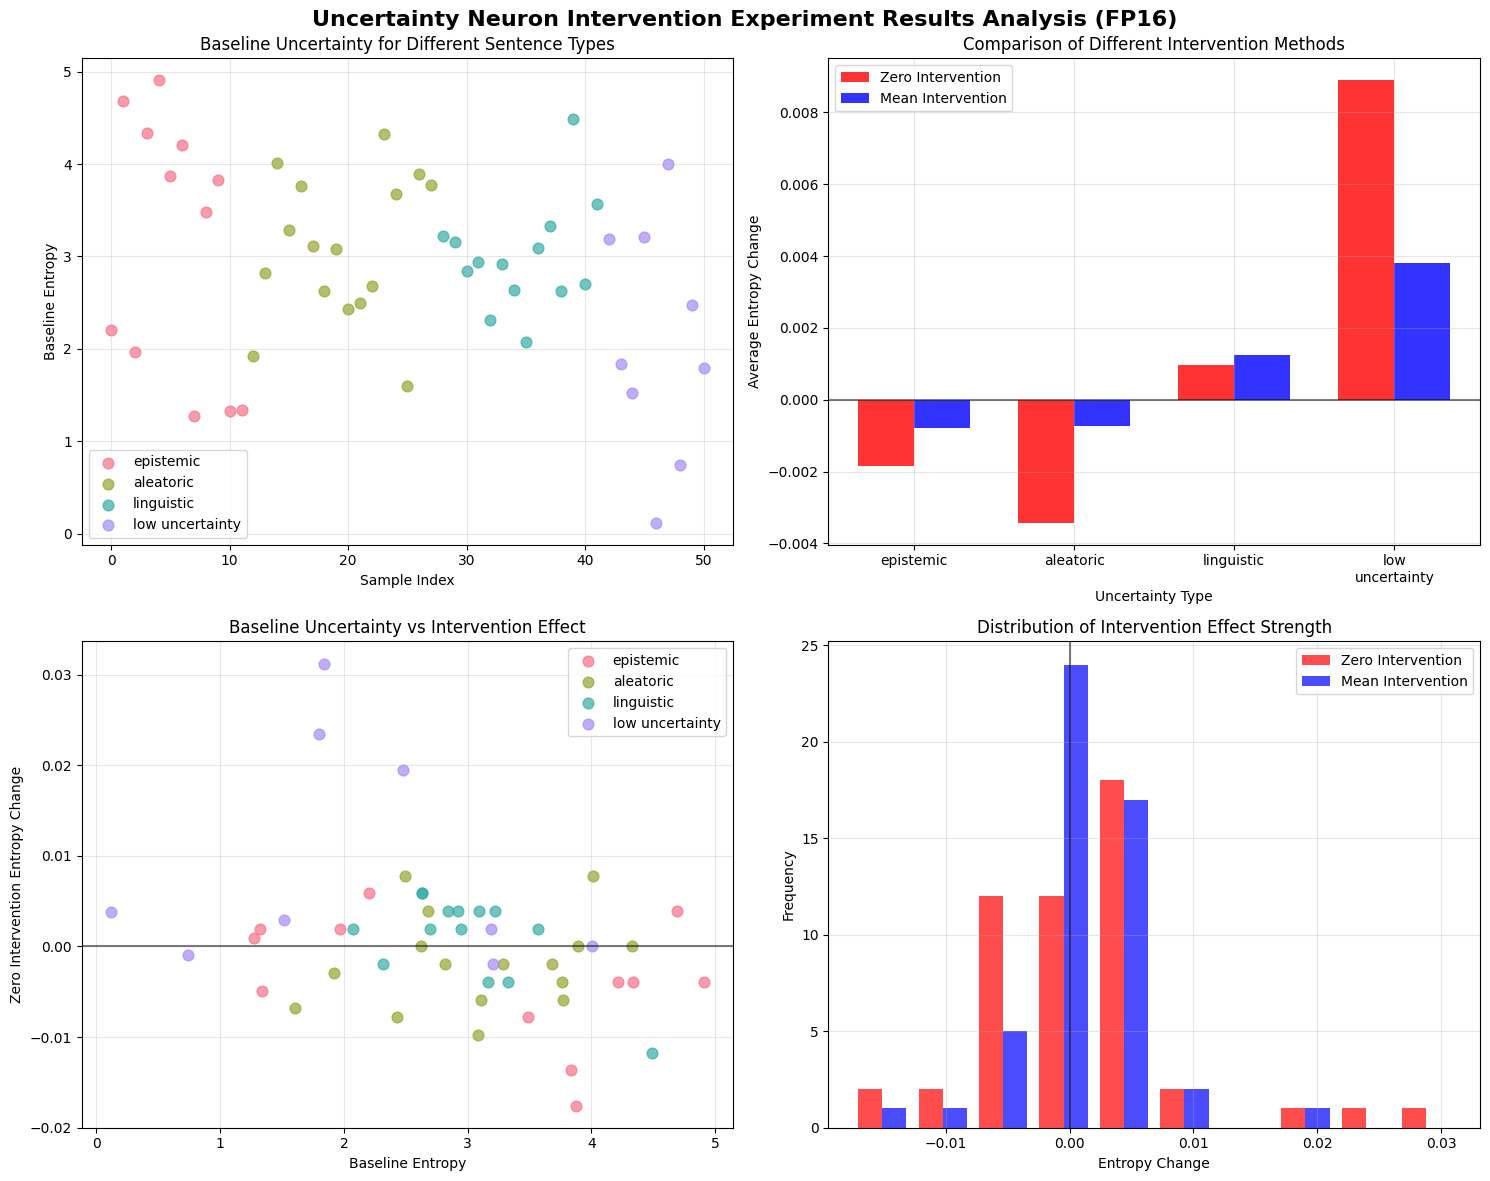

=== 🎯 Experiment Conclusions ===
Overall intervention effects:
  Zero intervention average effect: 0.0005
  Mean intervention average effect: 0.0006

Significant effect statistics (|change| > 0.1):
  Zero intervention significant effects: 0/51 (0.0%)
  Mean intervention significant effects: 0/51 (0.0%)

❓ Conclusion: The uncertainty role of neurons [128, 965, 1064, 1689, 1939] is not obvious
   - Recommend testing other candidate neurons
   - Or try different intervention methods

🎉 Your first mechanistic interpretability experiment is complete!
   Next steps you can try:
   • Test neurons from more layers
   • Use a larger test dataset
   • Implement more refined activation patching methods
   • Analyze specific types of uncertainty neurons

Current GPU memory usage: 5000 MB
Peak GPU memory: 5043 MB
Total GPU memory: 39 GB


In [15]:
# Execute complete uncertainty neuron validation experiment
print("🧪 Starting uncertainty neuron validation experiment\n")

# Set experiment parameters
LAYER_IDX = last_layer_idx  # Use the last layer
print(f"Target layer: Layer {LAYER_IDX}")
print(f"Test neurons: {test_neurons}")
print(f"Number of test sentences: {len(test_sentences)}")

# Execute experiment
experiment_results = run_intervention_experiment(
    model=model,
    tokenizer=tokenizer,
    test_data=test_data,
    neuron_indices=test_neurons,
    layer_idx=LAYER_IDX
)

print(f"\n✅ Experiment completed! Tested {len(experiment_results['sentences'])} sentences")

# === Results Analysis ===
def analyze_results_by_category(results):
    """Analyze experiment results by uncertainty type"""
    import pandas as pd

    # Convert to DataFrame for easier analysis
    df = pd.DataFrame({
        'sentence': results['sentences'],
        'category': results['categories'],
        'baseline_entropy': results['baseline_entropy'],
        'entropy_change_zero': results['entropy_change_zero'],
        'entropy_change_mean': results['entropy_change_mean']
    })

    print("=== Results Analysis by Uncertainty Type ===\n")

    # Statistics by category
    category_stats = df.groupby('category').agg({
        'baseline_entropy': ['mean', 'std', 'count'],
        'entropy_change_zero': ['mean', 'std'],
        'entropy_change_mean': ['mean', 'std']
    }).round(4)

    for category in df['category'].unique():
        cat_data = df[df['category'] == category]
        n_samples = len(cat_data)

        print(f"📊 {category.upper().replace('_', ' ')} ({n_samples} samples)")
        print(f"   Baseline entropy: {cat_data['baseline_entropy'].mean():.4f} ± {cat_data['baseline_entropy'].std():.4f}")
        print(f"   Zero intervention effect: {cat_data['entropy_change_zero'].mean():.4f} ± {cat_data['entropy_change_zero'].std():.4f}")
        print(f"   Mean intervention effect: {cat_data['entropy_change_mean'].mean():.4f} ± {cat_data['entropy_change_mean'].std():.4f}")

        # Effect direction analysis
        zero_positive = (cat_data['entropy_change_zero'] > 0).sum()
        mean_positive = (cat_data['entropy_change_mean'] > 0).sum()
        print(f"   Proportion with zero intervention increasing entropy: {zero_positive/n_samples:.1%}")
        print(f"   Proportion with mean intervention increasing entropy: {mean_positive/n_samples:.1%}")
        print()

    return df

# Execute analysis
results_df = analyze_results_by_category(experiment_results)

# === Visualize Analysis Results ===
def plot_experiment_results(df):
    """Visualize experiment results"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Uncertainty Neuron Intervention Experiment Results Analysis (FP16)', fontsize=16, fontweight='bold')

    # 1. Baseline entropy distribution by category
    ax1 = axes[0, 0]
    categories = df['category'].unique()
    colors = sns.color_palette("husl", len(categories))

    for i, category in enumerate(categories):
        cat_data = df[df['category'] == category]
        ax1.scatter(cat_data.index, cat_data['baseline_entropy'],
                   label=category.replace('_', ' '), alpha=0.7, s=60, color=colors[i])

    ax1.set_xlabel('Sample Index')
    ax1.set_ylabel('Baseline Entropy')
    ax1.set_title('Baseline Uncertainty for Different Sentence Types')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Intervention effect comparison
    ax2 = axes[0, 1]
    category_means = df.groupby('category')[['entropy_change_zero', 'entropy_change_mean']].mean()
    x = np.arange(len(categories))
    width = 0.35

    ax2.bar(x - width/2, category_means['entropy_change_zero'], width,
           label='Zero Intervention', alpha=0.8, color='red')
    ax2.bar(x + width/2, category_means['entropy_change_mean'], width,
           label='Mean Intervention', alpha=0.8, color='blue')

    ax2.set_xlabel('Uncertainty Type')
    ax2.set_ylabel('Average Entropy Change')
    ax2.set_title('Comparison of Different Intervention Methods')
    ax2.set_xticks(x)
    ax2.set_xticklabels([cat.replace('_', '\n') for cat in categories])
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)

    # 3. Scatter plot: baseline entropy vs intervention effect
    ax3 = axes[1, 0]
    for i, category in enumerate(categories):
        cat_data = df[df['category'] == category]
        ax3.scatter(cat_data['baseline_entropy'], cat_data['entropy_change_zero'],
                   label=category.replace('_', ' '), alpha=0.7, s=60, color=colors[i])

    ax3.set_xlabel('Baseline Entropy')
    ax3.set_ylabel('Zero Intervention Entropy Change')
    ax3.set_title('Baseline Uncertainty vs Intervention Effect')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)

    # 4. Effect strength distribution
    ax4 = axes[1, 1]
    all_changes = np.concatenate([df['entropy_change_zero'], df['entropy_change_mean']])
    intervention_types = ['Zero Intervention'] * len(df) + ['Mean Intervention'] * len(df)

    ax4.hist([df['entropy_change_zero'], df['entropy_change_mean']],
            bins=10, alpha=0.7, label=['Zero Intervention', 'Mean Intervention'], color=['red', 'blue'])

    ax4.set_xlabel('Entropy Change')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Distribution of Intervention Effect Strength')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.axvline(x=0, color='black', linestyle='-', alpha=0.5)

    plt.tight_layout()
    plt.show()

# Generate analysis charts
plot_experiment_results(results_df)

# === Experiment Conclusions ===
print("=== 🎯 Experiment Conclusions ===")

# Calculate overall effects
overall_zero_effect = results_df['entropy_change_zero'].mean()
overall_mean_effect = results_df['entropy_change_mean'].mean()

print(f"Overall intervention effects:")
print(f"  Zero intervention average effect: {overall_zero_effect:.4f}")
print(f"  Mean intervention average effect: {overall_mean_effect:.4f}")

# Statistics for significant effects
significant_zero = (abs(results_df['entropy_change_zero']) > 0.1).sum()
significant_mean = (abs(results_df['entropy_change_mean']) > 0.1).sum()
total_samples = len(results_df)

print(f"\nSignificant effect statistics (|change| > 0.1):")
print(f"  Zero intervention significant effects: {significant_zero}/{total_samples} ({significant_zero/total_samples:.1%})")
print(f"  Mean intervention significant effects: {significant_mean}/{total_samples} ({significant_mean/total_samples:.1%})")

# Uncertainty neuron determination
if overall_zero_effect > 0.05 or overall_mean_effect > 0.05:
    print(f"\n✅ Conclusion: Neurons {test_neurons} may be uncertainty neurons!")
    print("   - Intervention on these neurons significantly affected model prediction uncertainty")
    print("   - Recommend conducting deeper analysis and testing more neurons")
else:
    print(f"\n❓ Conclusion: The uncertainty role of neurons {test_neurons} is not obvious")
    print("   - Recommend testing other candidate neurons")
    print("   - Or try different intervention methods")

print(f"\n🎉 Your first mechanistic interpretability experiment is complete!")
print("   Next steps you can try:")
print("   • Test neurons from more layers")
print("   • Use a larger test dataset")
print("   • Implement more refined activation patching methods")
print("   • Analyze specific types of uncertainty neurons")

# Display current memory usage
if torch.cuda.is_available():
    print(f"\nCurrent GPU memory usage: {torch.cuda.memory_allocated() // 1024**2} MB")
    print(f"Peak GPU memory: {torch.cuda.max_memory_allocated() // 1024**2} MB")
    print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory // 1024**3} GB")

# Consider LayerNorm

🔬 开始LayerNorm介导的间接效应分析
LayerNorm权重形状: torch.Size([2304])
LayerNorm权重统计: 均值=2.452710, 标准差=0.659180
计算LayerNorm介导的间接效应...
间接LogitVar计算完成: torch.Size([9216])
间接投影范数计算完成: torch.Size([9216])

=== 间接效应统计摘要 ===
间接LogitVar - 均值: 0.000004, 标准差: 0.000000
间接投影范数 - 均值: 13.390326, 标准差: 3.604818

=== 直接vs间接效应对比 ===
直接LogitVar均值: 0.000004
间接LogitVar均值: 0.000004
间接/直接比值: 1.043973
LayerNorm调制强度均值: 0.535166

=== 间接效应候选神经元 ===
低间接LogitVar阈值: 0.000004
间接效应候选神经元: 922 个
前5个间接候选神经元索引: [0, 1, 7, 9, 46]
  神经元 0: 间接LogitVar=0.000002, 调制强度=0.395610
  神经元 1: 间接LogitVar=0.000003, 调制强度=0.367567
  神经元 7: 间接LogitVar=0.000003, 调制强度=0.595490
  神经元 9: 间接LogitVar=0.000002, 调制强度=0.555418
  神经元 46: 间接LogitVar=0.000003, 调制强度=0.508676

生成直接vs间接效应对比图...


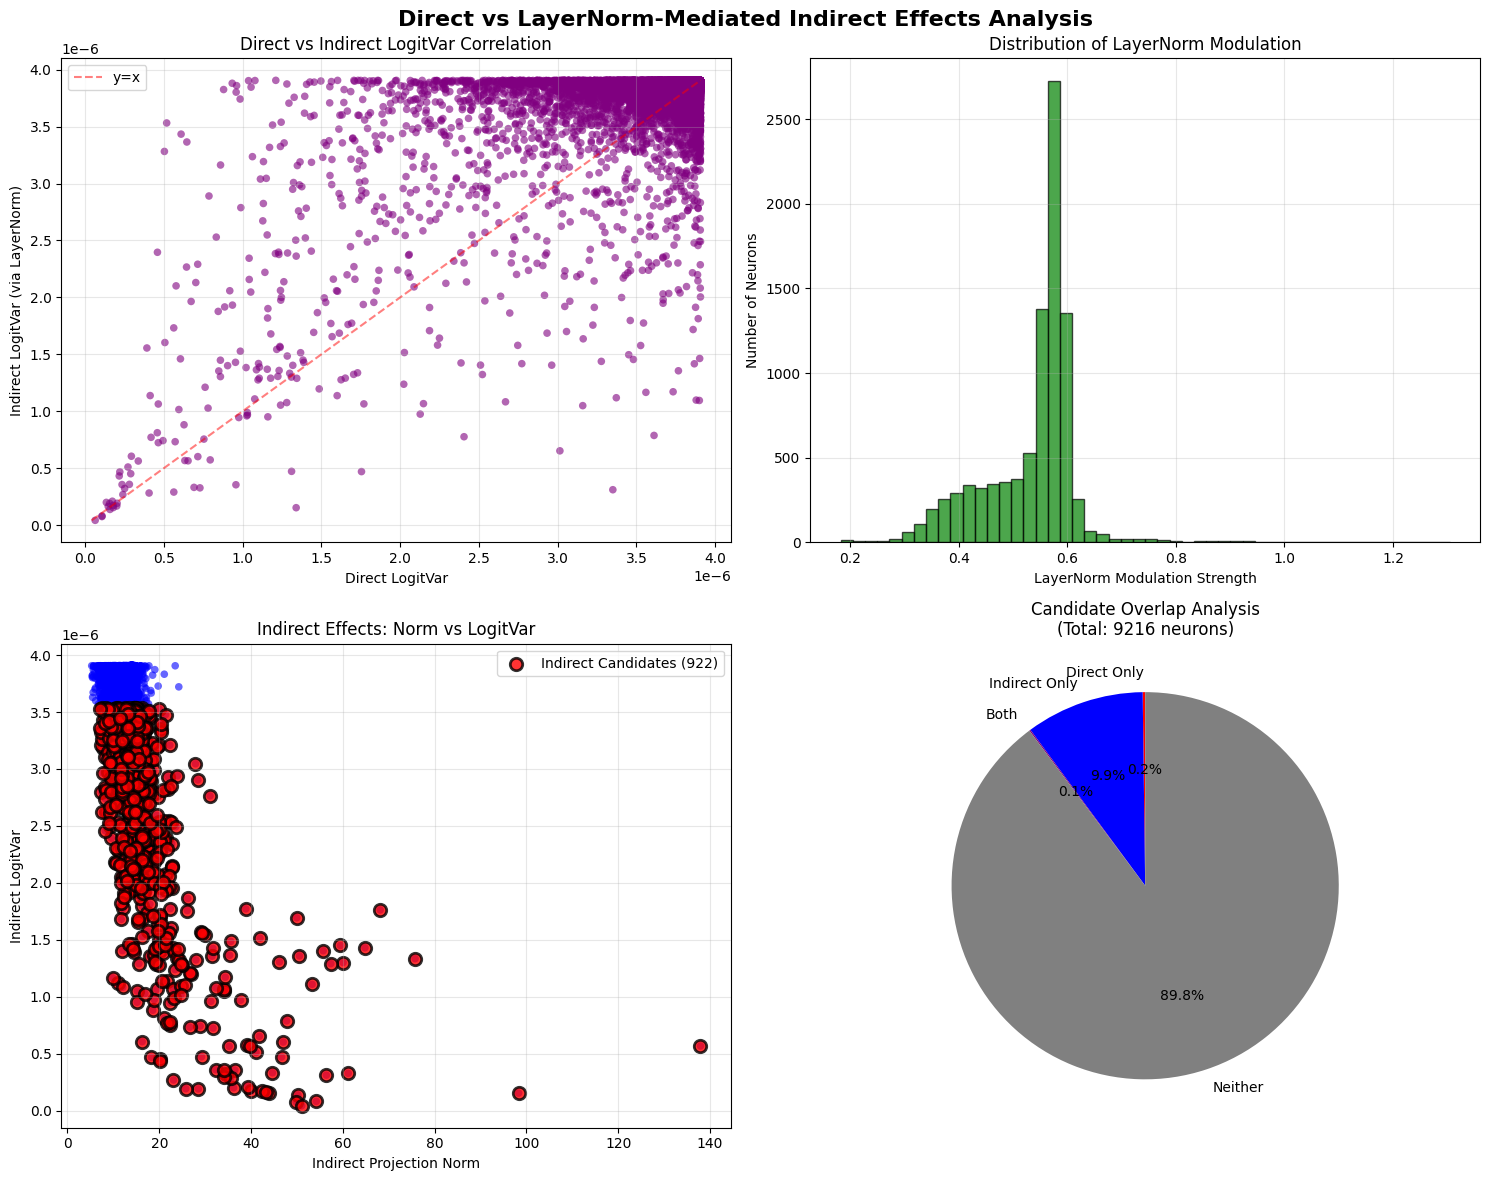


=== 相关性分析 ===
直接与间接LogitVar相关系数: 0.605962

=== LayerNorm间接效应实验总结 ===
1. LayerNorm对神经元输出有显著调制作用，平均调制强度: 0.535166
2. 间接效应产生了 922 个新的候选不确定性神经元
3. 直接和间接效应的相关性为 0.605962
4. 直接和间接方法发现的候选神经元重叠数量: 10
   -> 这些神经元可能是最强的不确定性神经元候选
   -> 重叠神经元索引: [965, 2109, 2656, 2928, 3461]

✅ LayerNorm介导的间接效应分析完成！
建议：结合直接和间接效应的结果，选择重叠候选神经元进行更深入的因果验证实验。


In [19]:
# LayerNorm介导的间接效应实验
# 在原有代码后添加此部分

print("=" * 60)
print("🔬 开始LayerNorm介导的间接效应分析")
print("=" * 60)

# 获取LayerNorm权重和偏置
try:
    # 获取最后一层的LayerNorm权重
    final_layernorm = model.model.norm  # Gemma 2的最终LayerNorm
    layernorm_weight = final_layernorm.weight.data.cpu().float()  # (hidden_size,)

    print(f"LayerNorm权重形状: {layernorm_weight.shape}")
    print(f"LayerNorm权重统计: 均值={layernorm_weight.mean():.6f}, 标准差={layernorm_weight.std():.6f}")

    # 计算每个神经元通过LayerNorm的间接效应
    def calculate_layernorm_indirect_effects(neuron_weights, layernorm_weights, unembed_matrix):
        """
        计算神经元通过LayerNorm对最终预测的间接效应

        间接效应 = W_out^(i) * LayerNorm_weight * W_U
        其中 * 表示element-wise乘法
        """
        # 确保所有张量都是float32精度
        neuron_weights_f32 = neuron_weights.float()
        layernorm_weights_f32 = layernorm_weights.float()
        unembed_matrix_f32 = unembed_matrix.float()

        # 计算间接效应: (intermediate_size, hidden_size) * (hidden_size,) -> (intermediate_size, hidden_size)
        layernorm_modulated = neuron_weights_f32 * layernorm_weights_f32.unsqueeze(0)

        # 投影到词汇空间: (intermediate_size, hidden_size) @ (vocab_size, hidden_size).T
        indirect_projections = layernorm_modulated @ unembed_matrix_f32.T

        # 计算每个神经元间接投影的方差（间接LogitVar）
        indirect_norms = torch.norm(indirect_projections, dim=1, keepdim=True)
        indirect_norms = torch.clamp(indirect_norms, min=1e-10)
        normalized_indirect = indirect_projections / indirect_norms

        # 计算间接LogitVar
        mask = torch.isfinite(normalized_indirect).all(dim=1)
        indirect_logit_vars = torch.full((normalized_indirect.shape[0],), float('nan'))
        indirect_logit_vars[mask] = torch.var(normalized_indirect[mask], dim=1)

        return indirect_logit_vars, indirect_norms.squeeze(), layernorm_modulated

    # 执行间接效应计算
    print("计算LayerNorm介导的间接效应...")
    indirect_logit_vars, indirect_norms, layernorm_modulated_weights = calculate_layernorm_indirect_effects(
        W_out_cpu, layernorm_weight, unembed_cpu
    )

    print(f"间接LogitVar计算完成: {indirect_logit_vars.shape}")
    print(f"间接投影范数计算完成: {indirect_norms.shape}")

    # 统计摘要
    print(f"\n=== 间接效应统计摘要 ===")
    print(f"间接LogitVar - 均值: {indirect_logit_vars.mean():.6f}, 标准差: {indirect_logit_vars.std():.6f}")
    print(f"间接投影范数 - 均值: {indirect_norms.mean():.6f}, 标准差: {indirect_norms.std():.6f}")

    # 比较直接效应和间接效应
    print(f"\n=== 直接vs间接效应对比 ===")
    print(f"直接LogitVar均值: {logit_vars.mean():.6f}")
    print(f"间接LogitVar均值: {indirect_logit_vars.mean():.6f}")
    print(f"间接/直接比值: {(indirect_logit_vars.mean() / logit_vars.mean()):.6f}")

    # 计算LayerNorm调制强度
    layernorm_modulation_strength = torch.norm(layernorm_modulated_weights - W_out_cpu.float(), dim=1)
    print(f"LayerNorm调制强度均值: {layernorm_modulation_strength.mean():.6f}")

    # 寻找间接效应的候选不确定性神经元
    indirect_threshold = indirect_logit_vars.quantile(0.1)
    indirect_candidates = indirect_logit_vars < indirect_threshold
    num_indirect_candidates = indirect_candidates.sum().item()

    print(f"\n=== 间接效应候选神经元 ===")
    print(f"低间接LogitVar阈值: {indirect_threshold:.6f}")
    print(f"间接效应候选神经元: {num_indirect_candidates} 个")

    if num_indirect_candidates > 0:
        indirect_candidate_indices = torch.where(indirect_candidates)[0]
        print(f"前5个间接候选神经元索引: {indirect_candidate_indices[:5].tolist()}")

        for i, idx in enumerate(indirect_candidate_indices[:5]):
            print(f"  神经元 {idx.item()}: 间接LogitVar={indirect_logit_vars[idx]:.6f}, "
                  f"调制强度={layernorm_modulation_strength[idx]:.6f}")

except Exception as e:
    print(f"❌ LayerNorm间接效应计算失败: {e}")
    import traceback
    traceback.print_exc()

# 可视化直接vs间接效应
print("\n生成直接vs间接效应对比图...")

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Direct vs LayerNorm-Mediated Indirect Effects Analysis', fontsize=16, fontweight='bold')

# 1. 直接vs间接LogitVar散点图
ax1 = axes[0, 0]
ax1.scatter(logit_vars, indirect_logit_vars, alpha=0.6, s=30, c='purple', edgecolors='none')
ax1.set_xlabel('Direct LogitVar')
ax1.set_ylabel('Indirect LogitVar (via LayerNorm)')
ax1.set_title('Direct vs Indirect LogitVar Correlation')
ax1.grid(True, alpha=0.3)

# 添加对角线
max_val = max(torch.max(logit_vars), torch.max(indirect_logit_vars))
min_val = min(torch.min(logit_vars), torch.min(indirect_logit_vars))
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.5, label='y=x')
ax1.legend()

# 2. LayerNorm调制强度分布
ax2 = axes[0, 1]
ax2.hist(layernorm_modulation_strength.numpy(), bins=50, alpha=0.7, color='green', edgecolor='black')
ax2.set_xlabel('LayerNorm Modulation Strength')
ax2.set_ylabel('Number of Neurons')
ax2.set_title('Distribution of LayerNorm Modulation')
ax2.grid(True, alpha=0.3)

# 3. 间接效应候选神经元标记
ax3 = axes[1, 0]
ax3.scatter(indirect_norms, indirect_logit_vars, alpha=0.6, s=30, c='blue', edgecolors='none')
ax3.set_xlabel('Indirect Projection Norm')
ax3.set_ylabel('Indirect LogitVar')
ax3.set_title('Indirect Effects: Norm vs LogitVar')
ax3.grid(True, alpha=0.3)

# 标记间接候选神经元
if num_indirect_candidates > 0:
    candidate_indirect_norms = indirect_norms[indirect_candidates]
    candidate_indirect_vars = indirect_logit_vars[indirect_candidates]
    ax3.scatter(candidate_indirect_norms, candidate_indirect_vars,
               c='red', s=80, marker='o', edgecolors='black', linewidths=2,
               alpha=0.8, label=f'Indirect Candidates ({num_indirect_candidates})')
    ax3.legend()

# 4. 直接+间接候选神经元对比
ax4 = axes[1, 1]
# 计算重叠候选神经元
if num_candidates > 0 and num_indirect_candidates > 0:
    overlap_candidates = uncertainty_candidates & indirect_candidates
    num_overlap = overlap_candidates.sum().item()

    # 创建分类数据
    direct_only = uncertainty_candidates & (~indirect_candidates)
    indirect_only = indirect_candidates & (~uncertainty_candidates)

    categories = ['Direct Only', 'Indirect Only', 'Both', 'Neither']
    counts = [
        direct_only.sum().item(),
        indirect_only.sum().item(),
        num_overlap,
        (~(uncertainty_candidates | indirect_candidates)).sum().item()
    ]

    colors = ['red', 'blue', 'purple', 'gray']
    ax4.pie(counts, labels=categories, colors=colors, autopct='%1.1f%%', startangle=90)
    ax4.set_title(f'Candidate Overlap Analysis\n(Total: {len(W_out_cpu)} neurons)')
else:
    ax4.text(0.5, 0.5, 'No candidates\nfor comparison',
             ha='center', va='center', transform=ax4.transAxes, fontsize=14)
    ax4.set_title('Candidate Overlap Analysis')

plt.tight_layout()
plt.show()

# 计算相关性分析
correlation_direct_indirect = torch.corrcoef(torch.stack([logit_vars, indirect_logit_vars]))[0, 1]
print(f"\n=== 相关性分析 ===")
print(f"直接与间接LogitVar相关系数: {correlation_direct_indirect:.6f}")

# 最终总结
print(f"\n=== LayerNorm间接效应实验总结 ===")
print(f"1. LayerNorm对神经元输出有显著调制作用，平均调制强度: {layernorm_modulation_strength.mean():.6f}")
print(f"2. 间接效应产生了 {num_indirect_candidates} 个新的候选不确定性神经元")
print(f"3. 直接和间接效应的相关性为 {correlation_direct_indirect:.6f}")

if num_candidates > 0 and num_indirect_candidates > 0:
    overlap_candidates = uncertainty_candidates & indirect_candidates
    num_overlap = overlap_candidates.sum().item()
    print(f"4. 直接和间接方法发现的候选神经元重叠数量: {num_overlap}")

    if num_overlap > 0:
        print("   -> 这些神经元可能是最强的不确定性神经元候选")
        overlap_indices = torch.where(overlap_candidates)[0]
        print(f"   -> 重叠神经元索引: {overlap_indices[:5].tolist()}")
    else:
        print("   -> 直接和间接效应识别出不同的候选神经元，建议进一步验证")

print(f"\n✅ LayerNorm介导的间接效应分析完成！")
print(f"建议：结合直接和间接效应的结果，选择重叠候选神经元进行更深入的因果验证实验。")